In [1]:
%%time

# Dependencies to Visualize the model
%matplotlib inline
from IPython.display import display, SVG
from PIL import Image
import matplotlib.pyplot as plt

# Filepaths, numpy, pandas, and Tensorflow
import os
import numpy as np
import pandas as pd
import tensorflow as tf

# Sklearn scaling
from sklearn.preprocessing import MinMaxScaler

# Keras
from keras.models import Sequential,Model
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D
from keras.preprocessing.image import ImageDataGenerator, load_img, image
from keras.applications import VGG16

# Shutil
import shutil

CPU times: user 1.21 s, sys: 374 ms, total: 1.58 s
Wall time: 2.38 s


Using TensorFlow backend.


In [2]:
#t_directories = pd.read_csv('food-101/meta/train.txt', header=None)
#tList = t_directories[0].tolist()

#c_directories = pd.read_csv('food-101/meta/classes.txt', header=None)
#cList = c_directories[0].tolist()

#fList = [s for s in tList if any(xs in s for xs in cList)]

#with open('train.txt', 'w') as f:
#    for item in fList:
#        f.write("%s\n" % item)

In [3]:
#Only run the below code once in order to create the training directory

folderList = []

folder_directories = pd.read_csv('food-101/meta/classes.txt', header=None) #reads the classes and folders found in food-101
fList = folder_directories[0].tolist()

for item in fList:
    folderList.append(os.path.join('train/image',item)) #creates directory paths for folders needed

for item in folderList:
    os.mkdir(item)

In [4]:
#Only run the below code once in order to create the test directory

testD = []

test_directories = pd.read_csv('food-101/meta/classes.txt', header=None) #reads the classes and folders found in food-101
tfList = test_directories[0].tolist()

for item in tfList:
    testD.append(os.path.join('validation/image',item)) #creates directory paths for folders needed

for item in testD:
    os.mkdir(item)

In [5]:
%%time

currentD = []
nextD = []

t_directories = pd.read_csv('food-101/meta/train.txt', header=None)
tList = t_directories[0].tolist()

for item in tList: #only necessary to create training directory
    currentD.append(os.path.join('food-101/image',item + '.jpg'))
    nextD.append(os.path.join('train/image', item + '.jpg'))

for i in range(len(currentD)): #Only run this command once in order to create the training directory for images
    shutil.copy(currentD[i], nextD[i])

CPU times: user 1.67 s, sys: 4.76 s, total: 6.44 s
Wall time: 13.6 s


In [6]:
%%time
existingD = []
validationD = []

v_directories = pd.read_csv('food-101/meta/test.txt', header=None)
vList = v_directories[0].tolist()

for item in vList: #only necessary to create test directory
    existingD.append(os.path.join('food-101/image',item + '.jpg'))
    validationD.append(os.path.join('validation/image', item + '.jpg'))

for i in range(len(existingD)): #Only run this command once in order to create the training directory for images
    shutil.copy(existingD[i], validationD[i])

CPU times: user 599 ms, sys: 1.67 s, total: 2.27 s
Wall time: 4.49 s


In [7]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [8]:
# defining directories and amount of images to train/validate
train_dir = 'train/image'
validation_dir = 'validation/image'

nTrain = 16500
nVal = 5500

In [9]:
%%time
# training images which belong to classes
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,22))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

i = 0
for inputs_batch, labels_batch in train_generator:
    
    features_batch = vgg_conv.predict(inputs_batch)
    
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nTrain:
        break
        
train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))

Found 16500 images belonging to 22 classes.
CPU times: user 12h 6min 13s, sys: 36min 14s, total: 12h 42min 28s
Wall time: 1h 9min 36s


In [115]:
train_labels[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

In [46]:
len(train_features[0])

25088

In [56]:
train_features[0]

array([0.        , 0.        , 0.        , ..., 0.        , 1.11723852,
       0.        ])

In [15]:
%%time
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim= 7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(22, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=32,
                    batch_size=batch_size)

Epoch 1/32
16500/16500 [==============================] - 102s 6ms/step - loss: 2.4722 - acc: 0.2751
Epoch 2/32
16500/16500 [==============================] - 107s 6ms/step - loss: 1.8438 - acc: 0.4532
Epoch 3/32
16500/16500 [==============================] - 106s 6ms/step - loss: 1.5807 - acc: 0.5296
Epoch 4/32
16500/16500 [==============================] - 98s 6ms/step - loss: 1.4027 - acc: 0.5797
Epoch 5/32
16500/16500 [==============================] - 102s 6ms/step - loss: 1.2583 - acc: 0.6185
Epoch 6/32
16500/16500 [==============================] - 99s 6ms/step - loss: 1.1480 - acc: 0.6496
Epoch 7/32
16500/16500 [==============================] - 99s 6ms/step - loss: 1.0417 - acc: 0.6867
Epoch 8/32
16500/16500 [==============================] - 100s 6ms/step - loss: 0.9690 - acc: 0.7039
Epoch 9/32
16500/16500 [==============================] - 99s 6ms/step - loss: 0.8909 - acc: 0.7242
Epoch 10/32
16500/16500 [==============================] - 99s 6ms/step - loss: 0.8256 - acc: 0

In [16]:
%%time

validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,22))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 5500 images belonging to 22 classes.
CPU times: user 4h 10min 12s, sys: 13min 6s, total: 4h 23min 19s
Wall time: 24min 6s


In [170]:
train_features[0].shape

(25088,)

In [17]:
%%time
history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 16500 samples, validate on 5500 samples
Epoch 1/20
16500/16500 [==============================] - 102s 6ms/step - loss: 0.3708 - acc: 0.9007 - val_loss: 2.0626 - val_acc: 0.6349
Epoch 2/20
16500/16500 [==============================] - 100s 6ms/step - loss: 0.3614 - acc: 0.8962 - val_loss: 2.1700 - val_acc: 0.6276
Epoch 3/20
16500/16500 [==============================] - 100s 6ms/step - loss: 0.3666 - acc: 0.9044 - val_loss: 2.1680 - val_acc: 0.6380
Epoch 4/20
16500/16500 [==============================] - 100s 6ms/step - loss: 0.3706 - acc: 0.9060 - val_loss: 2.1269 - val_acc: 0.6418
Epoch 5/20
16500/16500 [==============================] - 101s 6ms/step - loss: 0.3637 - acc: 0.9039 - val_loss: 2.1943 - val_acc: 0.6385
Epoch 6/20
16500/16500 [==============================] - 102s 6ms/step - loss: 0.3737 - acc: 0.9020 - val_loss: 2.2445 - val_acc: 0.6309
Epoch 7/20
16500/16500 [==============================] - 102s 6ms/step - loss: 0.3534 - acc: 0.9077 - val_loss: 2.2305 - v

In [19]:
model.save("food_trained.h5")

In [186]:
test_f = validation_features[0]

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               12845568  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 22)                11286     
Total params: 12,856,854
Trainable params: 12,856,854
Non-trainable params: 0
_________________________________________________________________


In [21]:
from keras.models import load_model
model = load_model("food_trained.h5")

In [27]:
fnames = validation_generator.filenames
 
ground_truth = validation_generator.classes
 
label2index = validation_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)
 
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 2015/5500


In [29]:


predictions = model.predict_classes(validation_features)


In [30]:
prob = model.predict(validation_features)

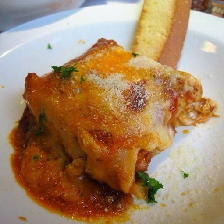

In [214]:
from keras.preprocessing import image
image_size = (224, 224)
im = image.load_img(validationD[3500], target_size=image_size)
im

In [215]:
from keras.preprocessing.image import img_to_array
image = img_to_array(im)
image.shape

(224, 224, 3)

In [216]:
# Scale the image pixels by 255 (or use a scaler from sklearn here)
image /= 255

# Flatten into a 1x28*28 array 
image_resized = image.flatten().reshape(-1, 7*7*512)

image_resized.shape

(6, 25088)

In [217]:
model.predict_classes(image_resized)
#image_resized)

array([18, 18, 18, 18, 18, 18])

In [218]:
idx2label

{0: 'apple_pie',
 1: 'caesar_salad',
 2: 'cannoli',
 3: 'cheesecake',
 4: 'chicken_wings',
 5: 'cup_cakes',
 6: 'donuts',
 7: 'french_fries',
 8: 'grilled_cheese_sandwich',
 9: 'guacamole',
 10: 'hamburger',
 11: 'hot_and_sour_soup',
 12: 'hot_dog',
 13: 'ice_cream',
 14: 'lasagna',
 15: 'oysters',
 16: 'pizza',
 17: 'spaghetti_carbonara',
 18: 'steak',
 19: 'sushi',
 20: 'tacos',
 21: 'waffles'}